In [323]:
from ipywidgets import *
from ipywidgets.widgets import IntSlider, FloatSlider
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.optimize import root

%matplotlib widget

interactive(children=(FloatSlider(value=1.0, description='L1', max=2.0, min=1.0, step=0.01), FloatSlider(value…

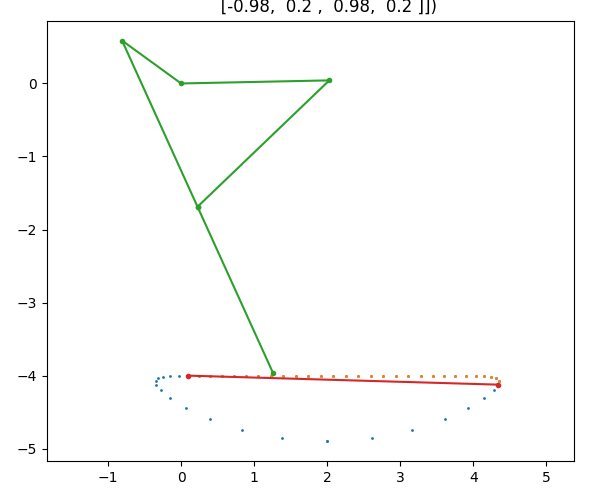

In [367]:
def get_path(dims, npts, guess=np.array([-0.8128368,0.58249149, 0.78720871, 0.61668667])):
    theta1_range = np.linspace(0, 2*pi, npts)
    path = []
    segment = []
    sols = []

    L1, L2, L3, L4, L5, theta5 = dims
    sin5 = sin(theta5)
    cos5 = cos(theta5)

    for theta1 in theta1_range:
        sin1 = sin(theta1)
        cos1 = cos(theta1) 
        def func_sincos(vars):
            sin2, cos2, sin3, cos3 = vars
            return [
                L1*sin1 + L2*sin2 + L3*sin3,
                L1*cos1 + L2*cos2 + L3*cos3 - L4, 
                sin2**2 + cos2**2 - 1,
                sin3**2 + cos3**2 - 1,        
            ]
        def jac_sincos(vars):
            sin2, cos2, sin3, cos3 = vars
            return [
                [L2, 0, L3, 0],
                [0, L2, 0, L3],
                [2*sin2, 2*cos2, 0, 0],
                [0, 0, 2*sin3, 2*cos3]
            ]
        
        sol = root(func_sincos, jac=jac_sincos, x0=guess, method='hybr').x
        sin2, cos2, sin3, cos3 = sol
        guess = sol

        p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])

        if(cos1*sin2 - sin1*cos2 > 0):
            segment.append(p5)
        path.append(p5)
        sols.append(sol)

    return np.array(path), np.array(segment), sols

def get_links(dims, sols, theta1_vis=0):
    L1, L2, L3, L4, L5, theta5 = dims
    sin1, cos1 = (sin(2*pi*theta1_vis/npts), cos(2*pi*theta1_vis/npts))
    sin5, cos5 = (sin(theta5), cos(theta5))
    sin2, cos2, sin3, cos3 = sols[theta1_vis]

    p0 = np.array([0, 0])
    p1 = p0 + L1*np.array([cos1, sin1])
    p2 = p1 + L2*np.array([cos2, sin2])
    p3 = p2 + L3*np.array([cos3, sin3])
    p4 = np.array([0, 0])
    p5 = L1*np.array([cos1, sin1]) + L2*np.array([cos2, sin2]) + L5*np.array([cos2*cos5-sin2*sin5, sin2*cos5+cos2*sin5])

    return np.array([p5, p2, p3, p4, p1, p2])

def douglas_peucker(points, epsilon):
    if len(points) <= 2:
        return points
    
    dmax = 0
    index = 0
    
    for i in range(1, len(points) - 1):
        d = perpendicular_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    
    if dmax > epsilon:
        recursive_result1 = douglas_peucker(points[:index + 1], epsilon)
        recursive_result2 = douglas_peucker(points[index:], epsilon)
        return np.concatenate((recursive_result1[:-1], recursive_result2))
    else:
        return np.array([points[0], points[-1]])

def perpendicular_distance(p, p1, p2):
    # Calculate the perpendicular distance of point p from line formed by p1 and p2
    return np.abs(np.cross(p2 - p1, p - p1)) / np.linalg.norm(p2 - p1)


dims = (1, 2.5, 2.5, 2, 2.5, radians(10))
npts = 50

path, segment, sols = get_path(dims, npts)
links = get_links(dims, sols)

path_simp = douglas_peucker(segment, 0.1)



plt.close()
fig = plt.figure(figsize=(6,5))
ax = fig.subplots(1, 1)
fig.tight_layout()
ax.axis('equal')
# ax.set_xlim(-4, 9)
# ax.set_ylim(-10, 3)

path_pts, = ax.plot(path[:,0], path[:,1], 'o', markersize=1)
segment_pts, = ax.plot(segment[:,0], segment[:,1], 'o', markersize=1)
link_pts, = ax.plot(links[:,0], links[:,1], 'o-', markersize=3)
simp_pts, = ax.plot(path_simp[:,0], path_simp[:,1], 'o-', markersize=3)

guess = np.array([-0.8128368,0.58249149, 0.78720871, 0.61668667])

def update(
        L1=FloatSlider(min=1, max=2, step=0.01, value=1),
        L2=FloatSlider(min=1, max=4, step=0.01, value=2.5),
        L3=FloatSlider(min=1, max=4, step=0.01, value=2.5),
        L4=FloatSlider(min=1, max=4, step=0.01, value=2),
        L5=FloatSlider(min=1, max=15, step=0.01, value=2.5),
        theta5=FloatSlider(min=-90, max=90, step=1, value=0),
        theta1_vis=IntSlider(min=0, max=npts-1, step=1, value=20),
        epsilon=FloatSlider(min=0, max=1, step=0.01, value=0.3),
        ):
    dims = (L1, L2, L3, L4, L5, radians(theta5))

    global guess
    path, segment, sols = get_path(dims, npts, guess=guess)
    # guess = sols[0]
    links = get_links(dims, sols, theta1_vis)
    path_simp = douglas_peucker(segment, epsilon)

    ax.set_title(repr(np.round(sols, 2)))
    
    path_pts.set_data((path[:,0], path[:,1]))
    segment_pts.set_data((segment[:,0], segment[:,1]))
    link_pts.set_data((links[:,0], links[:,1]))
    simp_pts.set_data((path_simp[:,0], path_simp[:,1]))

    fig.canvas.draw_idle()
    ax.relim()
    ax.autoscale_view(True,True,True)

_ = interact(update)

linkage for test stand: want something with low inertia, moves in a straight enough line, long stroke, 
links are at least 1" long, only one long link.

In [360]:
def douglas_peucker(points, epsilon):
    if len(points) <= 2:
        return points
    
    dmax = 0
    index = 0
    
    for i in range(1, len(points) - 1):
        d = perpendicular_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    
    if dmax > epsilon:
        recursive_result1 = douglas_peucker(points[:index + 1], epsilon)
        recursive_result2 = douglas_peucker(points[index:], epsilon)
        return np.concatenate((recursive_result1[:-1], recursive_result2))
    else:
        return np.array([points[0], points[-1]])

def perpendicular_distance(p, p1, p2):
    # Calculate the perpendicular distance of point p from line formed by p1 and p2
    return np.abs(np.cross(p2 - p1, p - p1)) / np.linalg.norm(p2 - p1)


def longest_straight_segment(points, threshold):
    n = len(points)
    dp = np.zeros(n)
    prev = np.zeros(n, dtype=int)

    for i in range(n):
        max_length = 0
        max_prev = -1
        
        for j in range(i - 1, -1, -1):
            if np.linalg.norm(points[i] - points[j]) <= threshold:
                length = np.linalg.norm(points[i] - points[j])
                if length > max_length:
                    max_length = length
                    max_prev = j
        
        dp[i] = max_length
        prev[i] = max_prev
    
    max_length = np.max(dp)
    end_index = np.argmax(dp)
    longest_segment = []
    
    while end_index != -1:
        longest_segment.append(points[end_index])
        end_index = prev[end_index]
    
    longest_segment.reverse()
    return np.array(longest_segment)



dims = (1, 2.5, 2.5, 2, 2.5, radians(10))
npts = 50

path, sols = get_path(dims, npts)

plt.close()
plt.figure()
plt.axis('equal')
plt.plot(path[:,0], path[:,1], 'o', markersize=1)

# path_simp = douglas_peucker(path, 0.1)
# plt.plot(path_simp[:,0], path_simp[:,1], 'o--', markersize=2)

seg = longest_straight_segment(path, threshold=2)
plt.plot(seg[:,0], seg[:,1], 'o--', markersize=2)



ValueError: too many values to unpack (expected 2)